<a href="https://colab.research.google.com/github/SAULIZA/nacimientos_defuncion/blob/main/Proyecto_def_nac_modelFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desarrollo del modelo del proyecto
**Proyecto 2 - Parte 4 (base)**
* Crado por: Saúl Iza
* Fecha de realización: 23/04/2023
* Fecha de modificación: 23/04/2023

## Garantiza que completes los pasos de preprocesamiento adecuados

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import set_config
set_config(display='diagram')

In [4]:
#Adquirimos los datos limpios desde la parte de visualización
df = pd.read_csv("/content/drive/MyDrive/Codificación de Dojo/Proyecto2/datos_nac_def_limpio.csv")

In [5]:
(df["anio"] <= 2020).sum()

1532771

In [6]:
(df["anio"] == 2020).sum()

223322

### Elección de las características más importantes

In [7]:
df.columns

Index(['sexo', 'sem_gest', 'anio', 'mes', 'p_emb', 'lugar_ocur', 'provincia',
       'canton', 'parroquia', 'asis_por', 'area', 'edad_mad', 'con_pren',
       'hij_viv', 'hij_vivm', 'hij_nacm', 'etnia', 'est_civil', 'sabe_leer',
       'niv_inst', 'prov_res', 'cant_res', 'parr_res', 'area_res', 'Estado',
       'nuev_estad'],
      dtype='object')

* Sex: el sexo del recién nacido o difunto si será tomado en cuenta
* Sem_gest: las semanas de gestación si se toman en cuenta (debido a que esta característica puede tener un peso considerable con respecto al resto aún está a discusión)
* Anio: El año de nacimiento o defunción no se considera una característica importante, sin embargo no lo eliminaremos pero luego si.
* Mes: El mes de nacimiento o defunción tampoco es una característica importante
* P_emb: El producto de embarazo si será tomda en cuenta
* Lugar_ocurr: el lugar de ocurrencia también será una característica importante a tomar en cuenta
* La provincia, cantón y área también se consideraran más no las parroquias (tanto de nacimientos, como de defunciones)
* El estado civil la etnia, y el nivel de instrucción de la madre también serán tomados en cuenta
* El estado también será eliminado ya que consideramos una nueva clase, en la columna nuevo estado se encuentran clasificados 3, uno de nacimiendo otro de nacido muerto y otro de aborto, según las semanas de gestación.
* Los hijos vivos, hijos nacidos vivos que han muerto, y los hijos que han nacido muertos también serán tomados en cuenta 

In [9]:
#variables que consideramos
col_selec = ['sexo','anio','p_emb','lugar_ocur','sem_gest',
        'asis_por','edad_mad','con_pren',
       'hij_viv', 'hij_vivm', 'hij_nacm','etnia','est_civil','sabe_leer',
       'niv_inst','prov_res', "Estado"]


In [10]:
#nuevo marco de datos con las columnas seleccionadas
data = df.loc[:,col_selec]

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750112 entries, 0 to 1750111
Data columns (total 17 columns):
 #   Column      Dtype  
---  ------      -----  
 0   sexo        object 
 1   anio        float64
 2   p_emb       object 
 3   lugar_ocur  object 
 4   sem_gest    float64
 5   asis_por    object 
 6   edad_mad    float64
 7   con_pren    float64
 8   hij_viv     float64
 9   hij_vivm    float64
 10  hij_nacm    float64
 11  etnia       object 
 12  est_civil   object 
 13  sabe_leer   object 
 14  niv_inst    object 
 15  prov_res    object 
 16  Estado      int64  
dtypes: float64(7), int64(1), object(9)
memory usage: 227.0+ MB


### Ingeniería de características

In [12]:
#haremos una sola columna con numero de hijos totales que nacieron vivos hij_viv + hij_vivm
data['ThijosV'] = data['hij_viv'] + data['hij_vivm'] 
data = data.drop(['hij_viv', 'hij_vivm'], axis=1)

* La variable nivel de instrucción, es una variable de tipo ordinal, por lo tanto vamos a ordenarlo de la siguiente manera:
0. Se ignora y ninguno
1. Primaria y Centro de alfabetizacion
2. Educación básica y Educacion Media / Bachillerato
3. Ciclo_post_bachillerato y Superior no universitario
4. Superior y Superior universitario
5. Posgrado


In [14]:
niv_instruccion = {'Se_ignora': 0, 'Ninguno': 0, 'Primaria': 1, "Centro_de_alfabetizacion":1, "Educacion_basica":2, "Educacion Media / Bachillerato":2,"Secundaria":2, "Ciclo_post_bachillerato":3, "Superior no universitario":3,"Superior":4,"Superior universitario":4,"Posgrado":5}
data["niv_inst"] = data["niv_inst"].replace(niv_instruccion)

* De igual manera el producto de embarazo es una variable de tipo ordinal, por lo tanto vamos a ordenarlo:
0. Simple
1. Doble
2. Triple
3. Cuadruple o más

In [15]:
prod_emb = {'Simple': 0, 'Doble': 1, "Triple":2, "Cuadruple_o_mas":3}
data["p_emb"] = data["p_emb"].replace(prod_emb)

* Tomaremos en cuenta también la provincia de residencia de la madre, tomaremos en cuenta las 5 provincias más pobladas y como una categoría especial que contenga al resto de provincias

In [16]:
data["prov_res"].value_counts()

Guayas                            436740
Pichincha                         271008
Manabi                            167679
Los Rios                          109599
El Oro                             82226
Azuay                              78050
Esmeraldas                         66102
Santo Domingo de los Tsachilas     58632
Tungurahua                         53680
Loja                               51374
Cotopaxi                           49552
Santa Elena                        48101
Imbabura                           42748
Chimborazo                         41776
Canar                              33623
Sucumbios                          27470
Morona Santiago                    23625
Orellana                           21663
Bolivar                            19361
Napo                               18895
Carchi                             16221
Pastaza                            14289
Zamora Chinchipe                   14028
Galapagos                           3194
Exterior        

### Train test split

* Este es un problema de predicción anual, por lo tanto vamos a hacer que los datos de entrenamiento sean los datos recolectados desde los años 2012 hasta 2020 y el conjunto de testeo sea del año 2021.

In [19]:
#filtramos los datos desde el 2012 hasta el 2020
df_2012_2020 = data[(data['anio'] >= 2012) & (data['anio'] <= 2020)]
# filtramos los datos del 2021
df_2021 = data[data['anio'] == 2021]

In [20]:
#comprobamos
df_2012_2020["anio"].value_counts()

2018.0    265923
2017.0    263558
2019.0    258668
2016.0    250567
2020.0    223322
2013.0    103954
2014.0     92392
2015.0     52417
2012.0     21970
Name: anio, dtype: int64

In [21]:
df_2021["anio"].value_counts()

2021.0    217341
Name: anio, dtype: int64

In [22]:
#test train split
#características
X_train = df_2012_2020.drop(["anio","Estado"], axis = 1)
X_test = df_2021.drop(["anio","Estado"], axis = 1)

y_train = df_2012_2020["Estado"]
y_test = df_2021["Estado"]

 ### Preparación de datos para aplicar modelos

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import set_config
set_config(display='diagram')

In [24]:
#Instanciamos column selector
num_selector = make_column_selector(dtype_include = "number")
cat_selector = make_column_selector(dtype_include = "object")

In [25]:
#instanciamos scaler para los datos numéricos
scaler = StandardScaler()
#instanciamos codificación one-hot-endoder para datos nominales
ohe_encoder = OneHotEncoder(drop = "first",sparse_output = False, handle_unknown = "ignore")

In [26]:
#creación de tuplas
num_tuple = (scaler, num_selector)
cat_tuple = (ohe_encoder, cat_selector)

In [27]:
#instanciamos column transform
col_transformer = make_column_transformer(num_tuple,cat_tuple, remainder = "passthrough")

In [28]:
#ajustamos a los datos de entrenamiento
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff7a9d33a00>),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff7a9d33250>)])

In [29]:
#transformacion de datos
X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)

## El modelo final escogido es el XGBoost, lo usaremos con los mejores hiperparámetros que se encontraron.

### Extreme Gradient Bosting

In [34]:
from xgboost import XGBClassifier

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
# Instantiate and fit gradient boosting classifier
xgb_best = XGBClassifier(max_depth= 5, n_estimators= 95)
xgb_best.fit(X_train_processed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=95, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [37]:
#grupo de entrenamiento
y_train_pred_xgb = xgb_best.predict(X_train_processed)
#grupo de testeo
y_test_pred_xgb = xgb_best.predict(X_test_processed)

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Métricas del modelo

* Grupo de entrenamiento

In [39]:
print(classification_report(y_train, y_train_pred_xgb))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86     10244
           1       1.00      1.00      1.00   1522527

    accuracy                           1.00   1532771
   macro avg       0.96      0.90      0.93   1532771
weighted avg       1.00      1.00      1.00   1532771



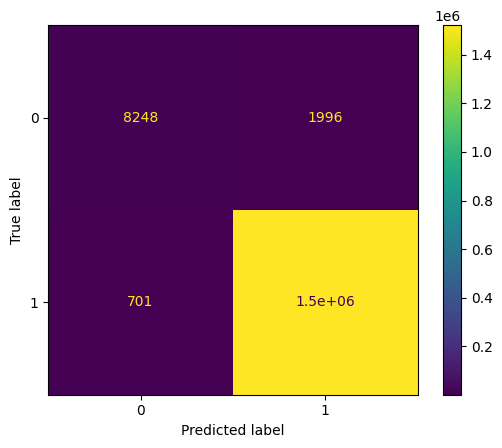

In [40]:
cm_xgb_train = confusion_matrix(y_train, y_train_pred_xgb)
disp = ConfusionMatrixDisplay(cm_xgb_train)
disp.plot();

* Grupo de testeo

In [41]:
print(classification_report(y_test, y_test_pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85      1300
           1       1.00      1.00      1.00    216041

    accuracy                           1.00    217341
   macro avg       0.95      0.90      0.92    217341
weighted avg       1.00      1.00      1.00    217341



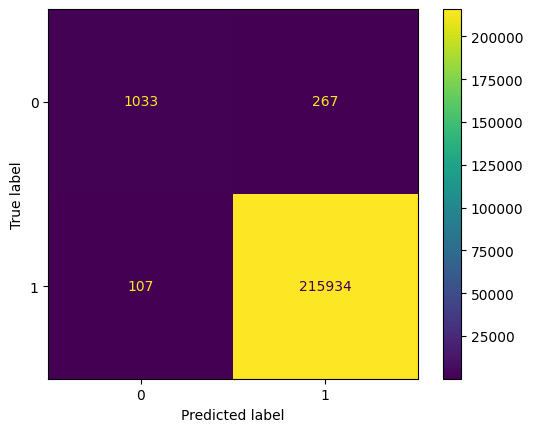

In [42]:
cm_xgb_test = confusion_matrix(y_test, y_test_pred_xgb)
disp = ConfusionMatrixDisplay(cm_xgb_test)
disp.plot();

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
auc = roc_auc_score(y_test,y_test_pred_xgb)
auc

0.8970600541279022

## Variables más representativas

Para encontrar las variables más representativas se realizo un analisis de rendimiento del modelo XGBoost que depende de cada variable, es decir, quitamos una variable y realizamos la clasificación, y vemos como afecta la ausencia de la misma al recall del modelo. 

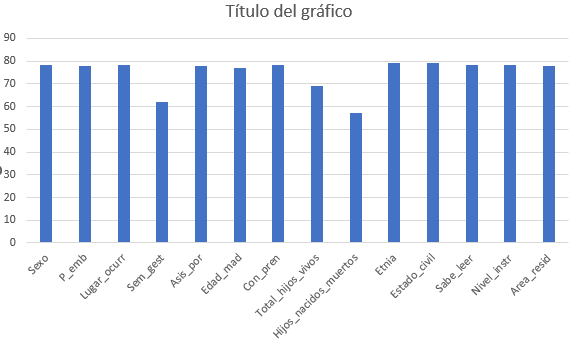

El rendimiento del modelo según el recall con ausencia de cada variable se lo realizó a mano, estos datos encontrados se recolectó en excel y luego se realizó un gráfico de los mismos (ver gráfico superior). Aquí se puede observar algunas variables que afectan mucho al rendimiento del modelo, a continuación vemos los más representativos.
1. Número de hijos nacidos muertos
2. Semanas de gestación
3. Número todal de hijos concebidos
4. Edad de la madre
5. Asistido por
6. Controles prenatales

* Se puede observar que entre las primeras causas de las defunciones fetales, se encuentran variables que dependen de la capacidad de la madre de dar a luz, o la incapacidad de dar a luz, por algúna razón.
* Las últimas variables están más relacionadas con la falta de acceso a medicos especialistas (obstetras) o a la falta de acceso a los controles prenatales.